# 1. Import Required Libraries

Import the necessary libraries, including pandas, numpy, matplotlib, seaborn, nltk, and sklearn.


In [ ]:
%pip intall -r requirements.txt --quiet

In [ ]:
# run this cell if you have problems with torch gpu
# or you want to use gpu instead of cpu
%pip uninstall torch torchvision torchaudio -y --quiet
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 --quiet

In [ ]:
# Import Required Libraries

import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For statistical data visualization
import nltk  # For natural language processing

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
)  # For text vectorization
from sklearn.naive_bayes import MultinomialNB  # For the Naive Bayes classifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
)  # For model evaluation
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch  # For tensor computation

# 2. Load Datasets

Load the tweets dataset using pandas.
we used 2 datasets

- `sentiments140` :This dataset contains 1.6 million tweets labeled as positive, negative
- `COVID-19 Tweets Sentiment Dataset`: This dataset contains tweets related to COVID-19, labeled as positive, negative, or neutral. It is used to understand public sentiment and behavior during the COVID-19 outbreak.


In [2]:
import os

DATA_DIR = "./data/"
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

DATASETS_DIR = os.listdir(DATA_DIR)
print(DATASETS_DIR)

RESULTS_DIR = "./results/"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

['cleaned_tweets.csv', 'corona_nlp_test.csv', 'corona_nlp_train.csv', 'models_evaluations_results.csv', 'sentiment140.csv']


In [11]:
# Load Covid 19 Dataset

# Load the tweets dataset using pandas
covid19_tweets_train_df = pd.read_csv(
    f"{DATA_DIR}/corona_nlp_train.csv", encoding="ISO-8859-1"
)
covid19_tweets_test_df = pd.read_csv(
    f"{DATA_DIR}/corona_nlp_test.csv", encoding="ISO-8859-1"
)

print(
    covid19_tweets_train_df.shape
)  # Display the number of rows and columns in the dataset
print(
    covid19_tweets_test_df.shape
)  # Display the number of rows and columns in the dataset
# Display the first few rows of the dataset to understand its structure
covid19_tweets_train_df.head()

(41157, 6)
(3798, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
#  Load the sentiment140 dataset

sentiment140_df = pd.read_csv(
    os.path.join(DATA_DIR, "sentiment140.csv"), encoding="latin-1", sep=",", header=None
)

#  we noticed that the columns names are messing we will fix them using the data discreption
sentiment140_df.columns = ["target", "ids", "date", "flag", "user", "text"]
print(sentiment140_df.shape)
sentiment140_df.head()

(1600000, 6)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# 3. Data Preprocessing

Handle missing values, duplicates, and other data cleaning tasks. And transform dataset to be uniform


## 3.1. Covid 19 Dataset


In [13]:
# check for missing values in the dataset
print(covid19_tweets_train_df.isna().sum())  # Check for missing values in the dataset
print(covid19_tweets_test_df.isna().sum())  # Check for missing values in the dataset

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64
UserName           0
ScreenName         0
Location         835
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


In [14]:
# replace the missing locations with unknown
# The `Location` attribute is used exclusively for visualization purposes in our workflow.
# Since missing location data does not affect model performance, we fill these null values with "Unknown" instead of dropping the corresponding records.
if "Location" in covid19_tweets_train_df.columns:
    covid19_tweets_train_df["Location"] = covid19_tweets_train_df["Location"].fillna(
        "Unknown"
    )

if "Location" in covid19_tweets_test_df.columns:
    covid19_tweets_test_df["Location"] = covid19_tweets_test_df["Location"].fillna(
        "Unknown"
    )


In [15]:
# check for missing values in the dataset
print(covid19_tweets_train_df.isna().sum())  # Check for missing values in the dataset
print(covid19_tweets_test_df.isna().sum())  # Check for missing values in the dataset

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


In [16]:
# Data Preprocessing


# Remove duplicate rows to ensure data quality
covid19_tweets_train_df.drop_duplicates(inplace=True)
covid19_tweets_test_df.drop_duplicates(inplace=True)

# Display the shape of the dataset after cleaning
print(covid19_tweets_train_df.shape)
print(covid19_tweets_test_df.shape)
# connvert the sentiments classes into two classes positive and negative by grouping the extreme classes
covid19_tweets_train_df["target"] = covid19_tweets_train_df["Sentiment"].map(
    {
        "Neutral": "Neutral",
        "Positive": "Positive",
        "Negative": "Negative",
        "Extremely Positive": "Positive",
        "Extremely Negative": "Negative",
    }
)
covid19_tweets_test_df["target"] = covid19_tweets_test_df["Sentiment"].map(
    {
        "Neutral": "Neutral",
        "Positive": "Positive",
        "Negative": "Negative",
        "Extremely Positive": "Positive",
        "Extremely Negative": "Negative",
    }
)
# Basic statistics of the dataset to understand its distribution
print(
    "------covid19 train dataframe info:------------",
    covid19_tweets_train_df.info(),
    sep="\n",
)
print(
    "------covid19 test dataframe info:-------------",
    covid19_tweets_test_df.info(),
    sep="\n",
)

(41157, 6)
(3798, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       41157 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
 6   target         41157 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.2+ MB
------covid19 train dataframe info:------------
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       3798 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTwee

In [17]:
# checking unique values in the dataset
print("covid test dataset unique values: ", covid19_tweets_test_df.nunique(), sep="\n")
print(
    "covid train dataset unique values: ", covid19_tweets_train_df.nunique(), sep="\n"
)

covid test dataset unique values: 
UserName         3798
ScreenName       3798
Location         1701
TweetAt            15
OriginalTweet    3798
Sentiment           5
target              3
dtype: int64
covid train dataset unique values: 
UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
target               3
dtype: int64


In [18]:
print("covid test data types: ", covid19_tweets_test_df.dtypes, sep="\n")
print("covid train data types: ", covid19_tweets_train_df.dtypes, sep="\n")

covid test data types: 
UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
target           object
dtype: object
covid train data types: 
UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
target           object
dtype: object


In [19]:
# Convert TweetAt column to datetime
covid19_tweets_train_df["TweetAt"] = pd.to_datetime(
    covid19_tweets_train_df["TweetAt"], utc=True
)

# extract the year and month from the date column for better understanding of trends
covid19_tweets_train_df["year"] = covid19_tweets_train_df["TweetAt"].dt.year
covid19_tweets_train_df["month"] = covid19_tweets_train_df["TweetAt"].dt.month

C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\3216855193.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  covid19_tweets_train_df["TweetAt"] = pd.to_datetime(


In [20]:
covid19_tweets_train_df.loc[:, "text_length"] = covid19_tweets_train_df.loc[
    :, "OriginalTweet"
].apply(len)
covid19_tweets_test_df.loc[:, "text_length"] = covid19_tweets_test_df.loc[
    :, "OriginalTweet"
].apply(len)

## 3.2. Sentiment140 Dataset


In [21]:
# checking unique values in the dataset
print("sentiments140 unique values: ", sentiment140_df.nunique(), sep="\n")

sentiments140 unique values: 
target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64


In [22]:
# we noticed that the flag column has only one value  we will drop it
sentiment140_df.drop(columns=["flag"], inplace=True)
sentiment140_df.head()

,target,ids,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [23]:
print("sentiment140 data types: ", sentiment140_df.dtypes, sep="\n")

sentiment140 data types: 
target     int64
ids        int64
date      object
user      object
text      object
dtype: object


In [ ]:
# Convert date column to datetime
sentiment140_df["date"] = pd.to_datetime(sentiment140_df["date"], utc=True)

# extract the year and month from the date column for better understanding of trends
sentiment140_df["year"] = sentiment140_df["date"].dt.year
sentiment140_df["month"] = sentiment140_df["date"].dt.month


C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\4074735148.py:2: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  sentiment140_df["date"] = pd.to_datetime(sentiment140_df["date"], utc=True)


In [25]:
sentiment140_df.loc[:, "text_length"] = sentiment140_df.loc[:, "text"].apply(len)

## 3.3. Dataset transformation

transform both datasets to use the same structures and columns names


In [29]:
print("covid train columns", covid19_tweets_train_df.columns, sep="\n")
print("covid test columns", covid19_tweets_test_df.columns, sep="\n")
print("sentiment140 columns", sentiment140_df.columns, sep="\n")

covid train columns
Index(['Location', 'date', 'text', 'Sentiment', 'target', 'year', 'month',
       'text_length'],
      dtype='object')
covid test columns
Index(['Location', 'date', 'text', 'Sentiment', 'target', 'text_length'], dtype='object')
sentiment140 columns
Index(['target', 'date', 'text', 'year', 'month', 'text_length'], dtype='object')


In [27]:
#  rename the columns from covid19 dataset to match the sentiment140 dataset
covid19_tweets_train_df.rename(
    columns={"OriginalTweet": "text", "TweetAt": "date"},
    inplace=True,
)
covid19_tweets_test_df.rename(
    columns={"OriginalTweet": "text", "TweetAt": "date"},
    inplace=True,
)

In [28]:
#  drop the columns that are not essintial
covid19_tweets_train_df.drop(columns=["UserName", "ScreenName"], inplace=True)
covid19_tweets_test_df.drop(columns=["UserName", "ScreenName"], inplace=True)
sentiment140_df.drop(columns=["ids", "user"], inplace=True)

# 4. Exploratory Data Analysis

Perform EDA to understand the distribution of sentiments, tweet lengths, and other relevant insights.


## 4.1. Ploting Sentiment distrubtion


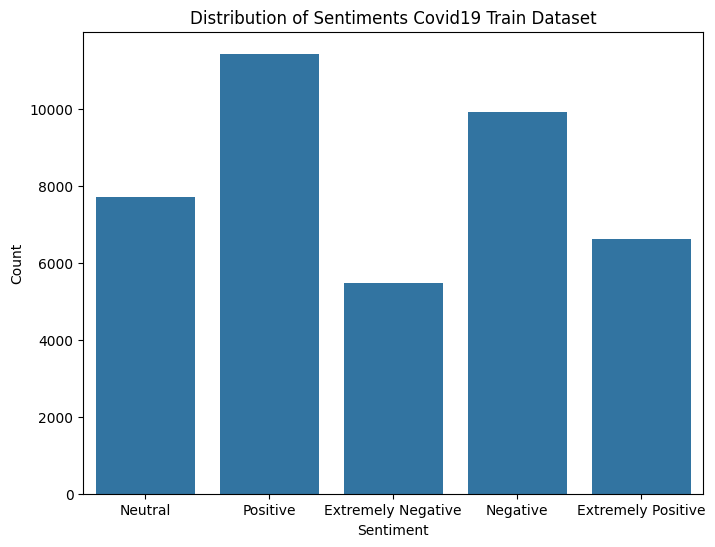

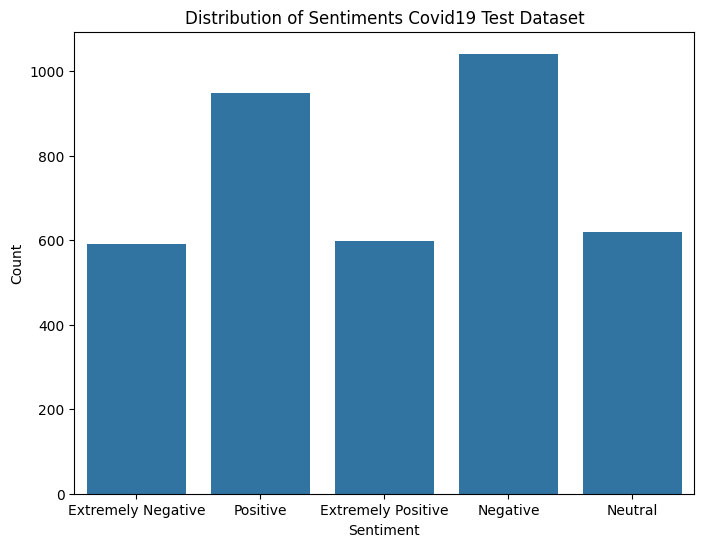

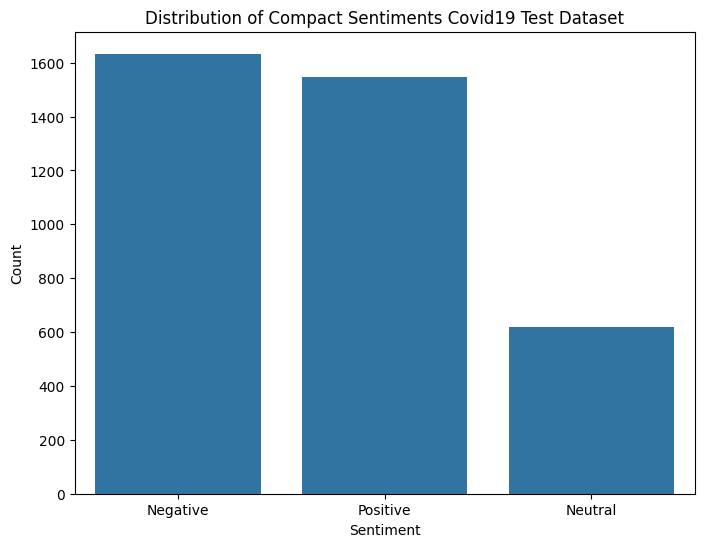

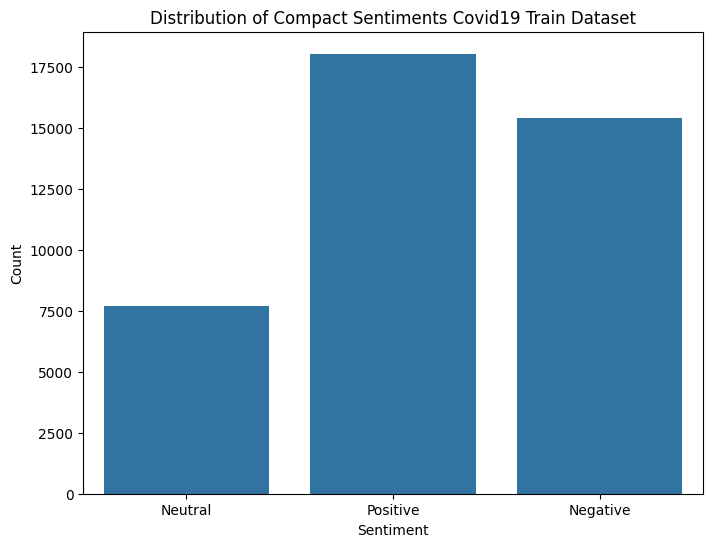

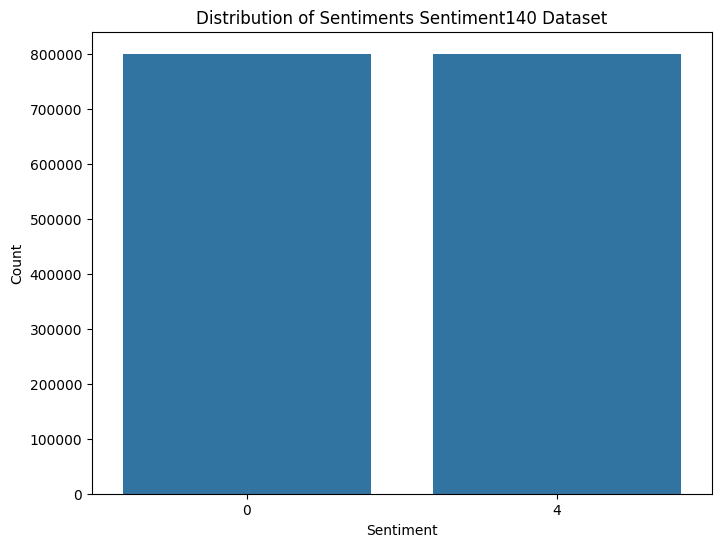

In [ ]:
# Distribution of sentiments
def plot_sentiments_distribution(dataset, sentiment_column: str, title: str):
    """
    Function to plot the distribution of sentiments in the dataset
    """
    plt.figure(figsize=(8, 6))
    sns.countplot(x=sentiment_column, data=dataset)
    plt.title(title)
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


plot_sentiments_distribution(
    covid19_tweets_train_df,
    "Sentiment",
    "Distribution of Sentiments Covid19 Train Dataset",
)
plot_sentiments_distribution(
    covid19_tweets_test_df,
    "Sentiment",
    "Distribution of Sentiments Covid19 Test Dataset",
)
plot_sentiments_distribution(
    covid19_tweets_test_df,
    "target",
    "Distribution of Compact Sentiments Covid19 Test Dataset",
)
plot_sentiments_distribution(
    covid19_tweets_train_df,
    "target",
    "Distribution of Compact Sentiments Covid19 Train Dataset",
)
plot_sentiments_distribution(
    sentiment140_df, "target", "Distribution of Sentiments Sentiment140 Dataset"
)


## 4.2. Ploting tweet length distrubtion


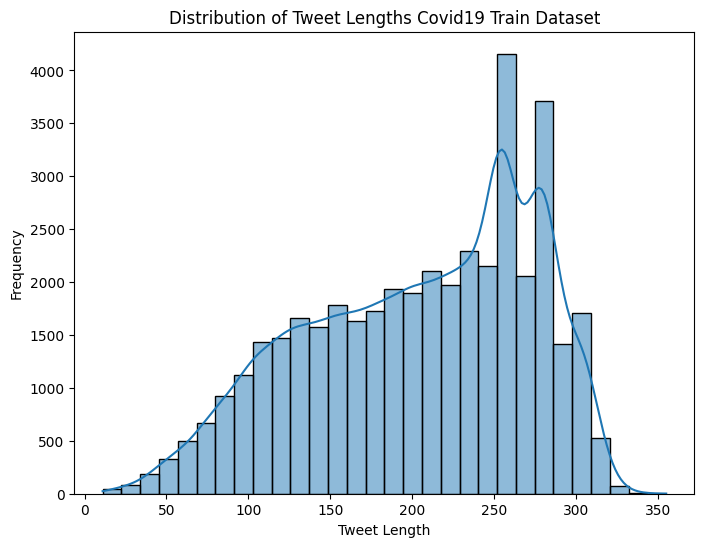

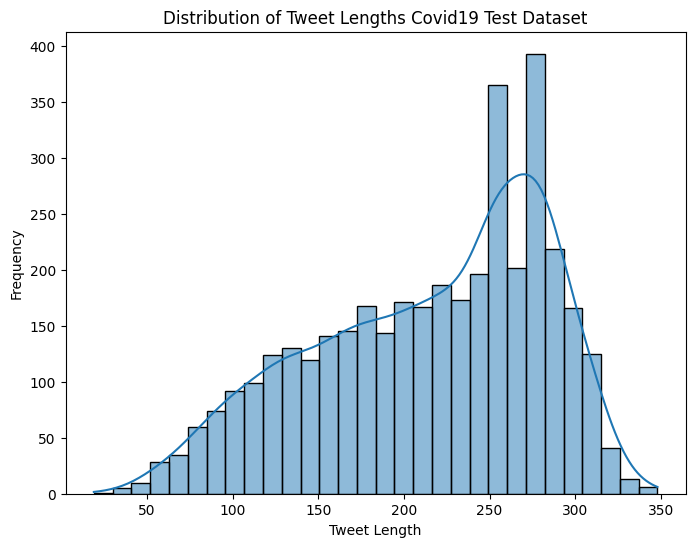

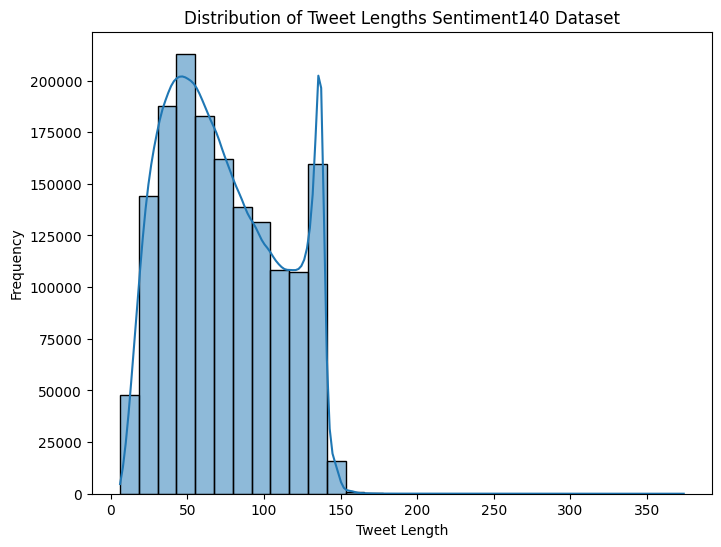

In [47]:
# Distribution of tweet lengths
def plot_tweet_length_distribution(dataset, title: str):
    """
    Function to plot the distribution of tweet lengths in the dataset
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(dataset["text_length"], bins=30, kde=True)
    plt.title(title)
    plt.xlabel("Tweet Length")
    plt.ylabel("Frequency")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


plot_tweet_length_distribution(
    covid19_tweets_train_df, "Distribution of Tweet Lengths Covid19 Train Dataset"
)
plot_tweet_length_distribution(
    covid19_tweets_test_df, "Distribution of Tweet Lengths Covid19 Test Dataset"
)
plot_tweet_length_distribution(
    sentiment140_df, "Distribution of Tweet Lengths Sentiment140 Dataset"
)

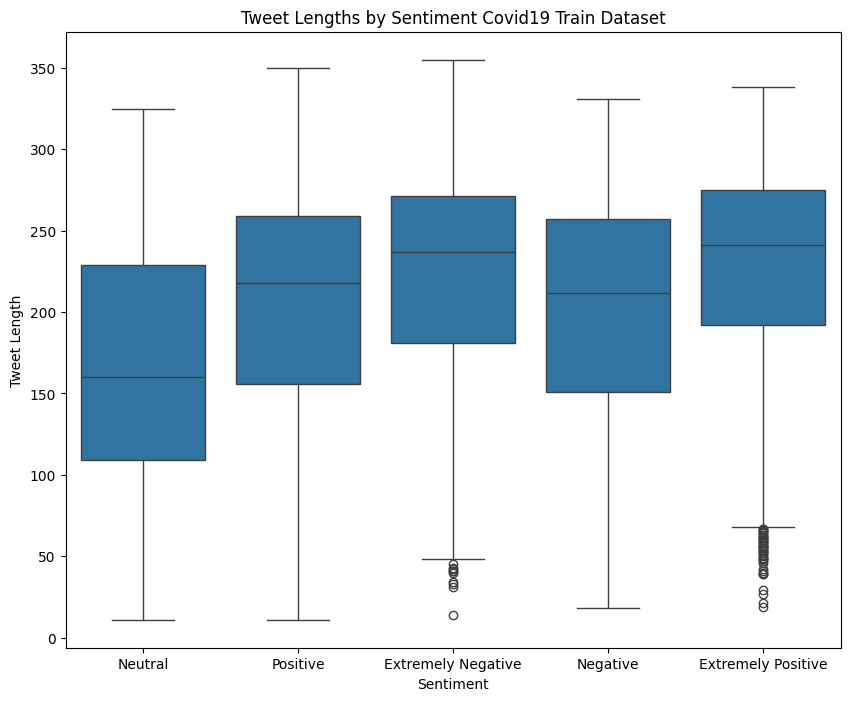

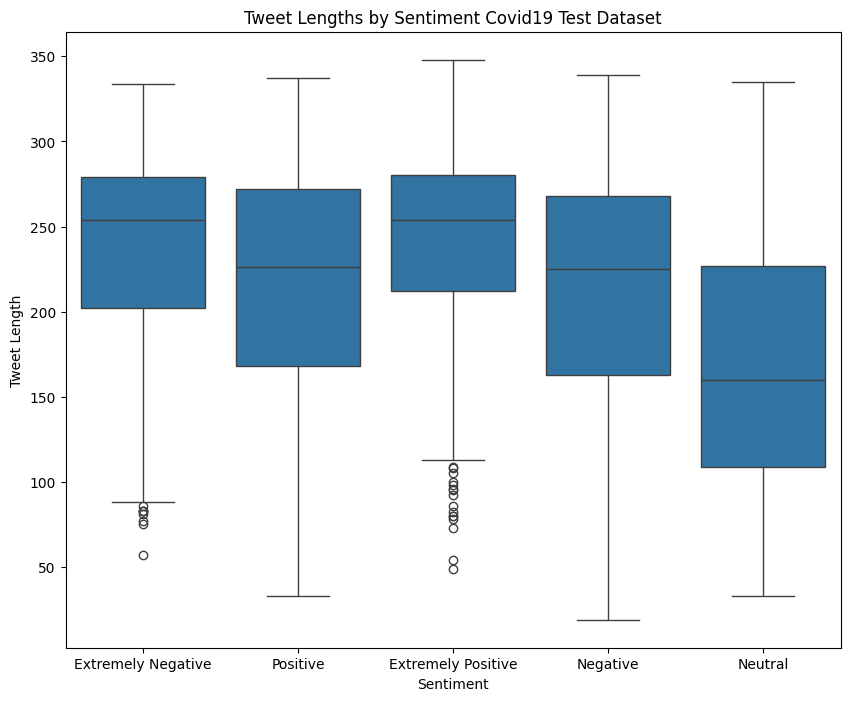

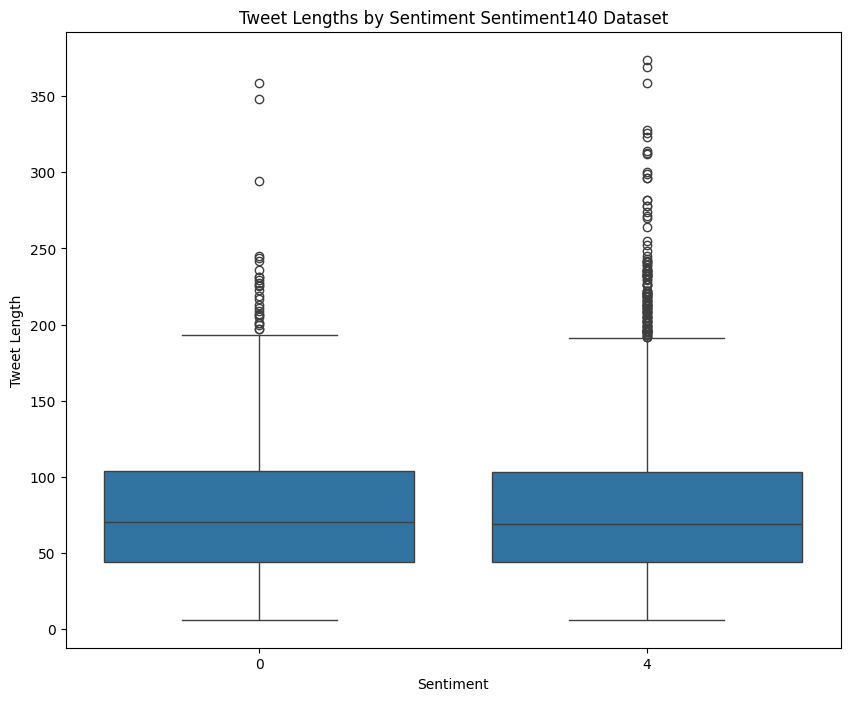

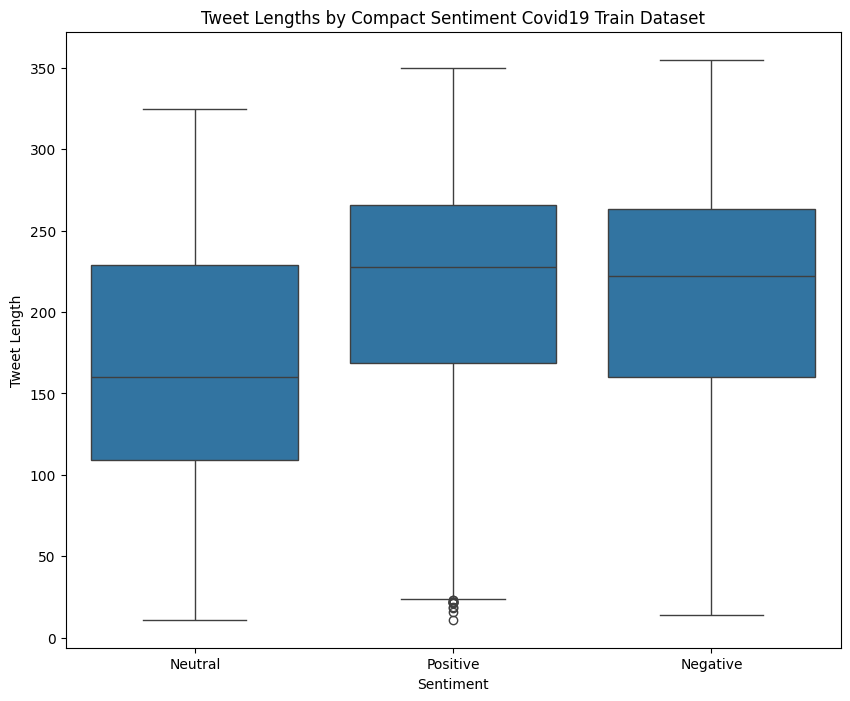

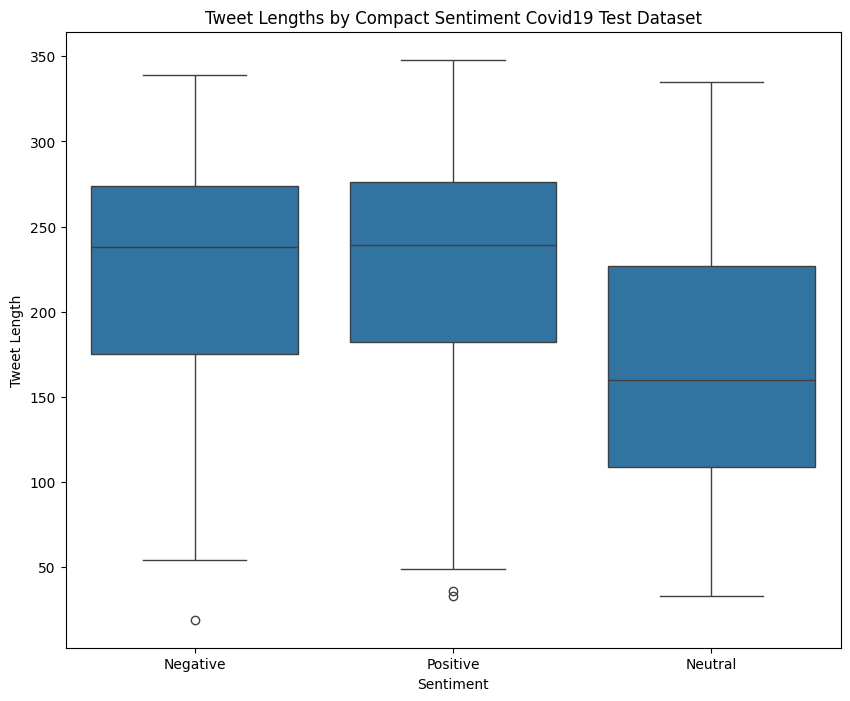

In [49]:
# Boxplot of tweet lengths by sentiment
def plot_tweet_length_by_sentiment(dataset, title: str, sentiments_column: str):
    """
    Function to plot the tweet lengths by sentiment in the dataset
    """
    plt.figure(figsize=(10, 8))
    sns.boxplot(x=sentiments_column, y="text_length", data=dataset)
    plt.title(title)
    plt.xlabel("Sentiment")
    plt.ylabel("Tweet Length")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


plot_tweet_length_by_sentiment(
    covid19_tweets_train_df,
    "Tweet Lengths by Sentiment Covid19 Train Dataset",
    "Sentiment",
)
plot_tweet_length_by_sentiment(
    covid19_tweets_test_df,
    "Tweet Lengths by Sentiment Covid19 Test Dataset",
    "Sentiment",
)
plot_tweet_length_by_sentiment(
    sentiment140_df, "Tweet Lengths by Sentiment Sentiment140 Dataset", "target"
)
plot_tweet_length_by_sentiment(
    covid19_tweets_train_df,
    "Tweet Lengths by Compact Sentiment Covid19 Train Dataset",
    "target",
)
plot_tweet_length_by_sentiment(
    covid19_tweets_test_df,
    "Tweet Lengths by Compact Sentiment Covid19 Test Dataset",
    "target",
)


## 4.3. Ploting word clouds


In [ ]:
%pip install wordcloud --quiet

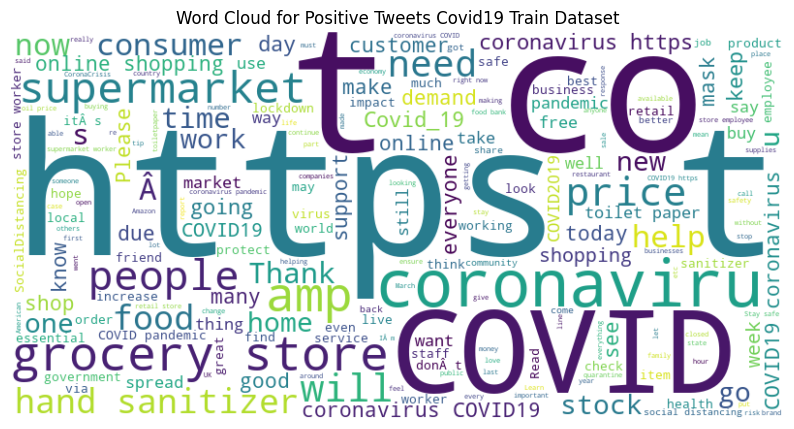

C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\1184679469.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


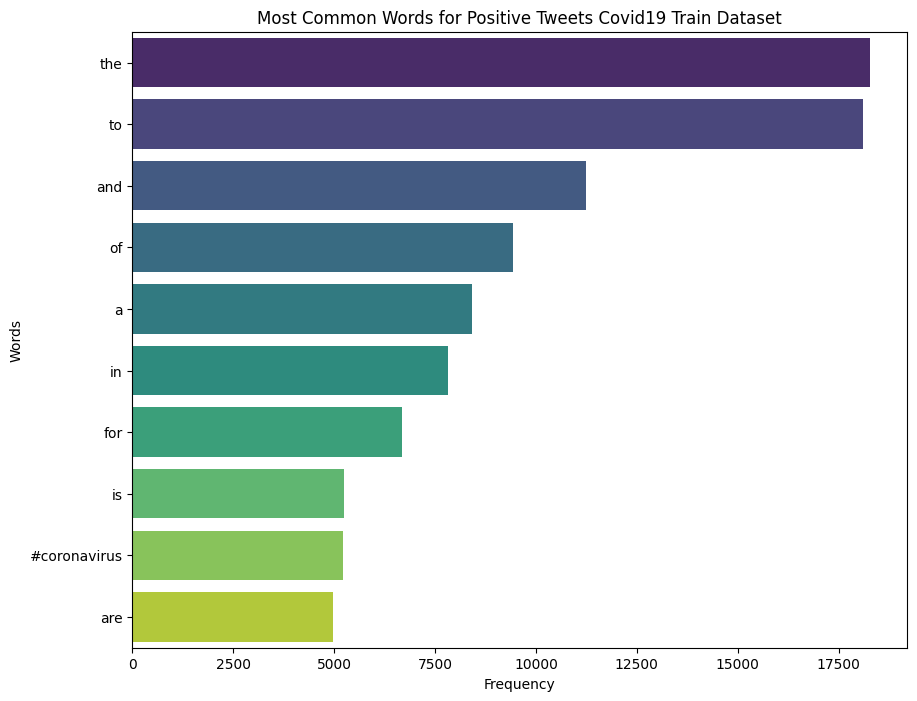

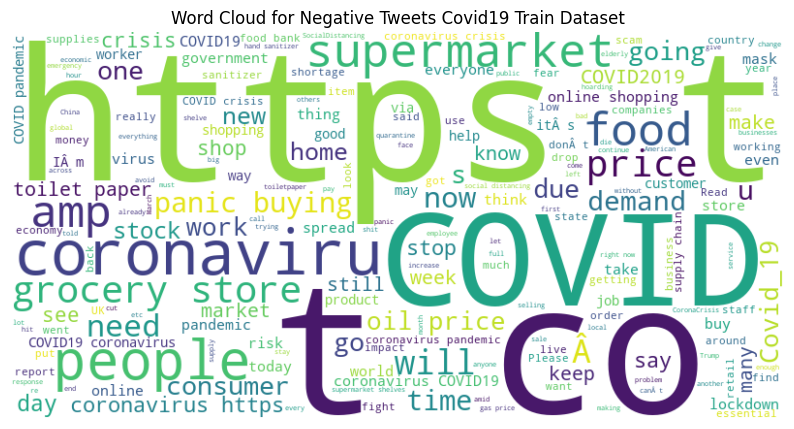

C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\1184679469.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


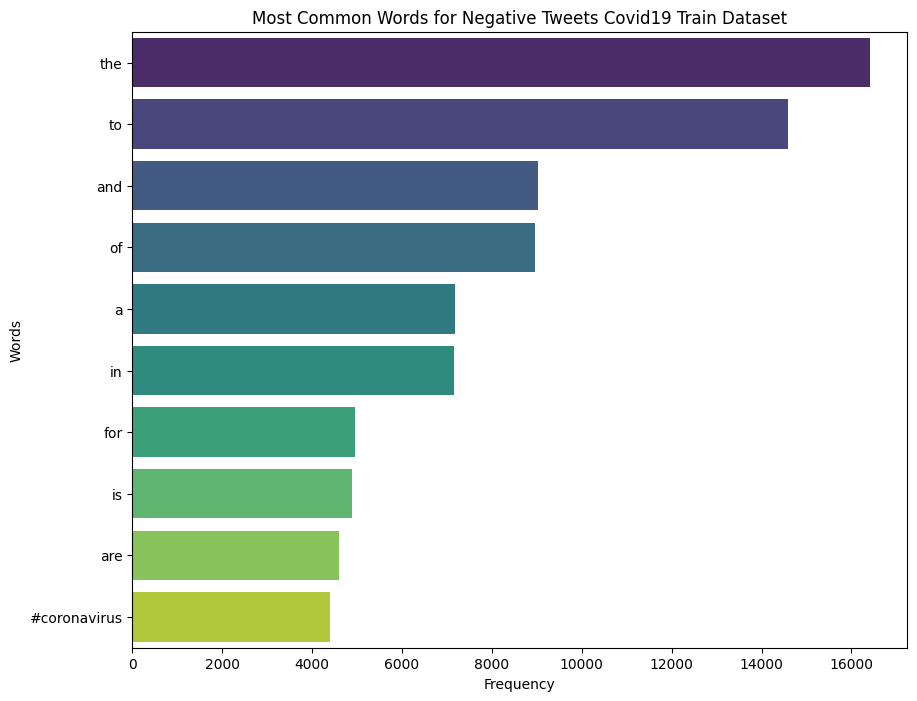

In [81]:
# Word cloud for positive tweets
from wordcloud import WordCloud
from collections import Counter


def plot_word_cloud(sentiment_tweets, title: str):
    """
    Function to plot the word cloud for the specified sentiment in the dataset
    """

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        sentiment_tweets
    )

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


def plot_most_common_words(sentiment_tweets, title: str):
    """
    Function to plot the most common words for the specified sentiment in the dataset
    """

    words = sentiment_tweets.split()
    word_counts = Counter(words)
    word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))

    plt.figure(figsize=(10, 8))
    sns.barplot(
        x=list(word_counts.values())[:10],
        y=list(word_counts.keys())[:10],
        palette="viridis",
    )
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.savefig(f"{RESULTS_DIR}/{title}.png")
    plt.show()


positive_tweets = " ".join(
    covid19_tweets_train_df[(covid19_tweets_train_df["target"] == "Positive")]["text"]
)

plot_word_cloud(positive_tweets, "Word Cloud for Positive Tweets Covid19 Train Dataset")
plot_most_common_words(
    positive_tweets, "Most Common Words for Positive Tweets Covid19 Train Dataset"
)

negative_tweets = " ".join(
    covid19_tweets_train_df[(covid19_tweets_train_df["target"] == "Negative")]["text"]
)
plot_word_cloud(negative_tweets, "Word Cloud for Negative Tweets Covid19 Train Dataset")
plot_most_common_words(
    negative_tweets, "Most Common Words for Negative Tweets Covid19 Train Dataset"
)

# to ensure safe memory usage we will delete the dataframes that we will not use
del positive_tweets, negative_tweets

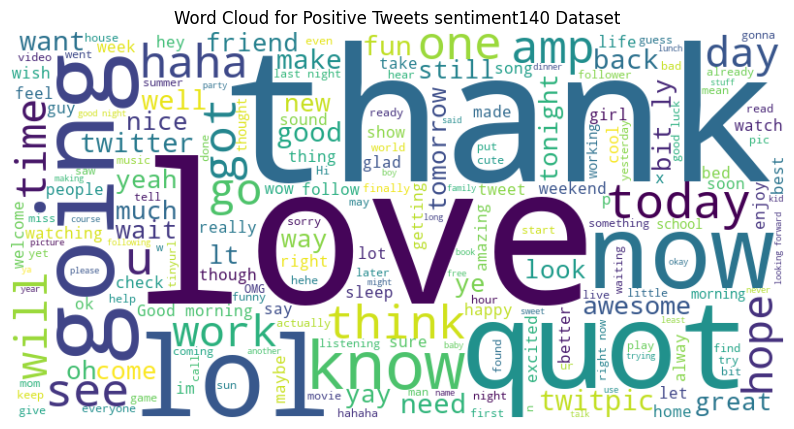

C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\1184679469.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


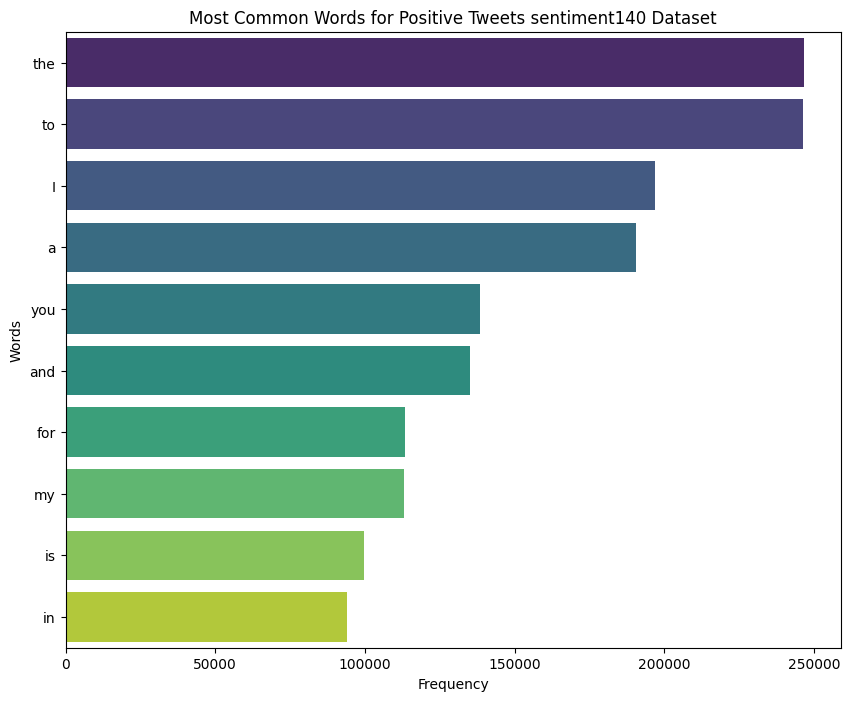

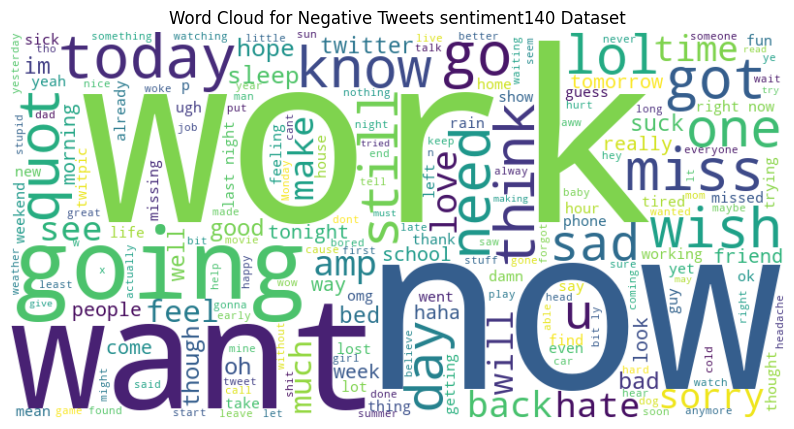

C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\1184679469.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


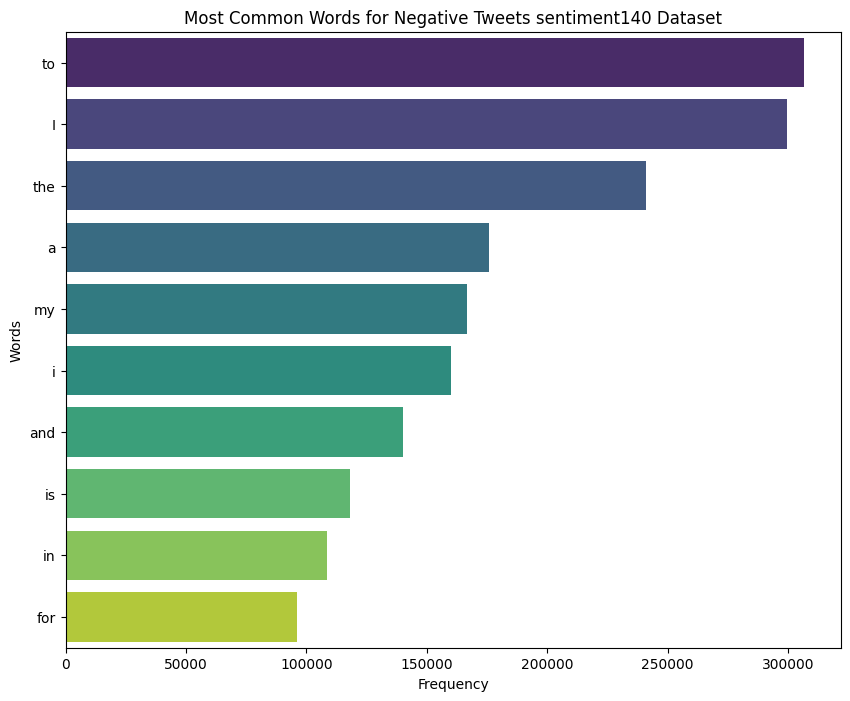

In [89]:
positive_tweets = " ".join(sentiment140_df[(sentiment140_df["target"] == 4)]["text"])

plot_word_cloud(positive_tweets, "Word Cloud for Positive Tweets sentiment140 Dataset")
plot_most_common_words(
    positive_tweets, "Most Common Words for Positive Tweets sentiment140 Dataset"
)

negative_tweets = " ".join(sentiment140_df[(sentiment140_df["target"] == 0)]["text"])
plot_word_cloud(negative_tweets, "Word Cloud for Negative Tweets sentiment140 Dataset")
plot_most_common_words(
    negative_tweets, "Most Common Words for Negative Tweets sentiment140 Dataset"
)

# to ensure safe memory usage we will delete the dataframes that we will not use
del positive_tweets, negative_tweets


## 4.4. Ploting tweet distrubtion by date


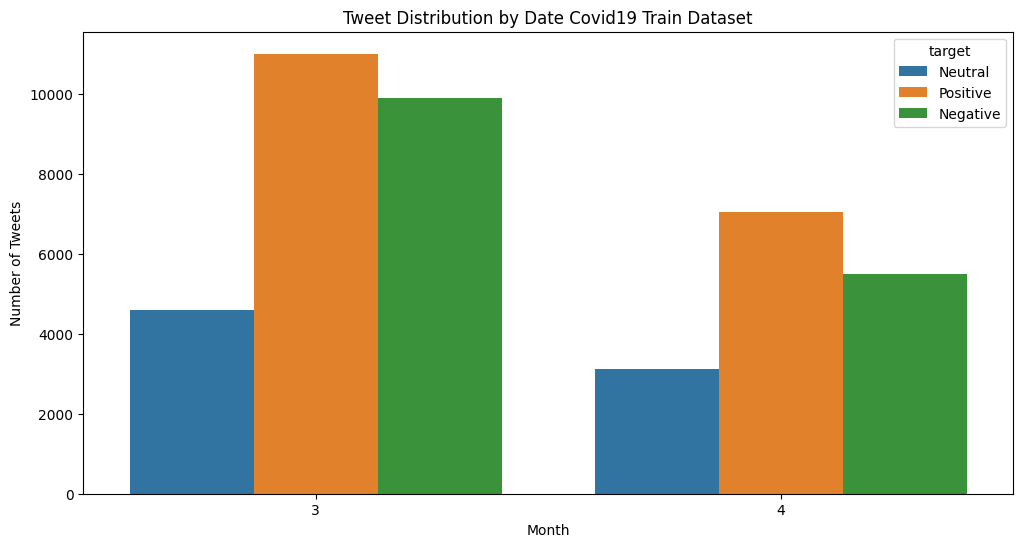

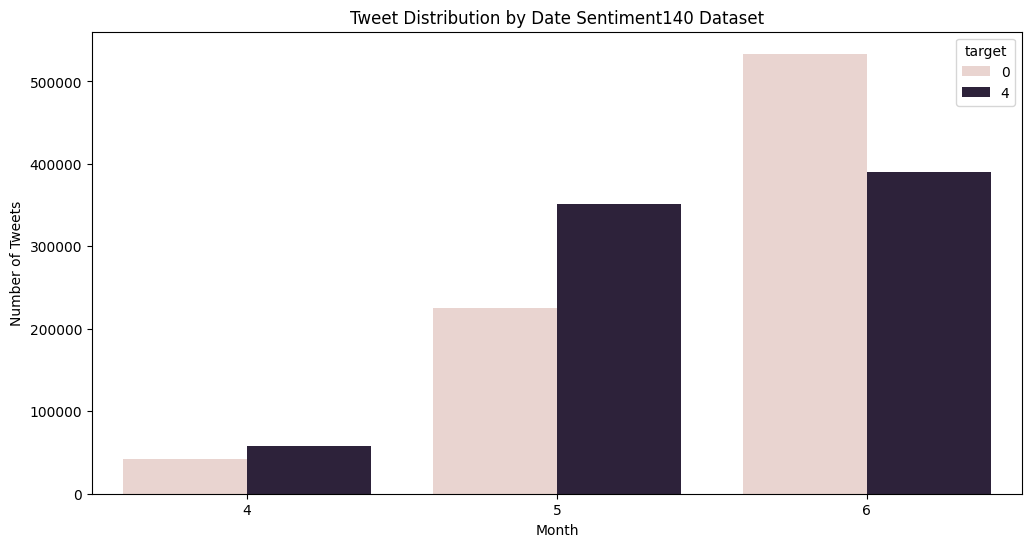

In [64]:
def plot_tweet_distribution_by_month(dataset, title: str):
    """
    Function to plot the tweet distribution by month in the dataset
    """

    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataset, x="month", hue="target")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Number of Tweets")
    plt.savefig(RESULTS_DIR + f"{title}.png")
    plt.show()


plot_tweet_distribution_by_month(
    covid19_tweets_train_df, "Tweet Distribution by Date Covid19 Train Dataset"
)

plot_tweet_distribution_by_month(
    sentiment140_df, "Tweet Distribution by Date Sentiment140 Dataset"
)


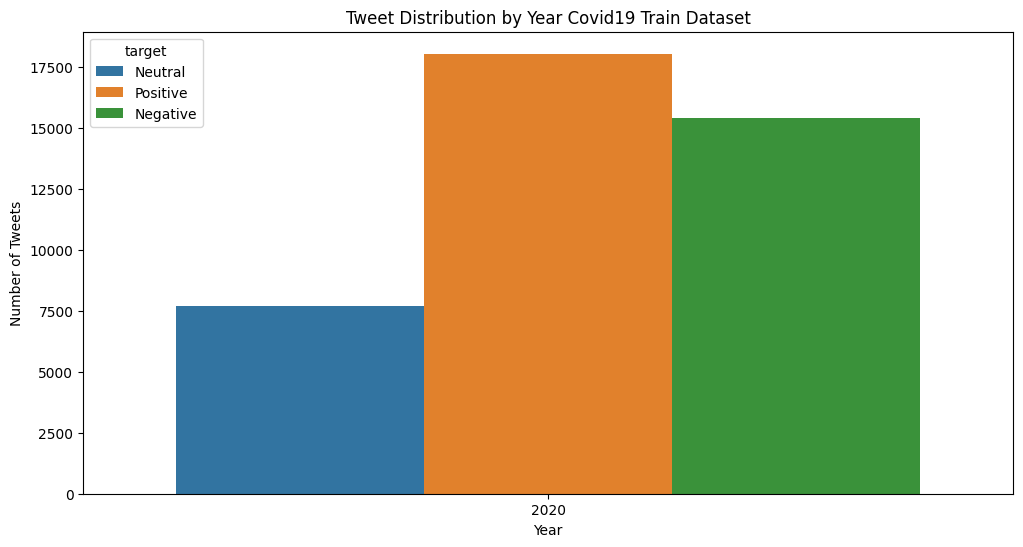

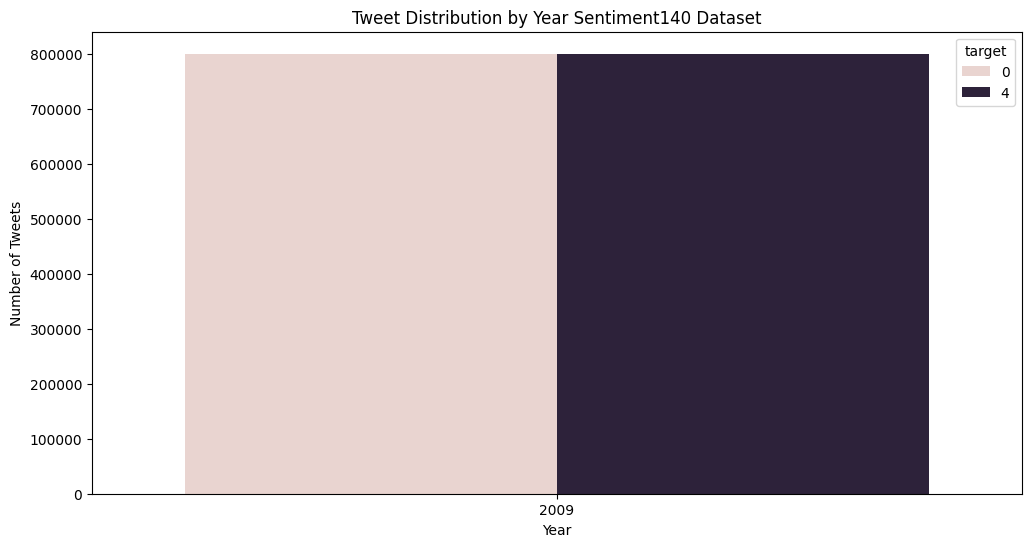

In [63]:
# visualize thetype of the tweet for by month and year
def plot_tweet_distribution_by_year(dataset, title: str):
    """
    Function to plot the tweet distribution by year in the dataset
    """

    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataset, x="year", hue="target")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Number of Tweets")
    plt.savefig(RESULTS_DIR + f"{title}.png")
    plt.show()


plot_tweet_distribution_by_year(
    covid19_tweets_train_df, "Tweet Distribution by Year Covid19 Train Dataset"
)

plot_tweet_distribution_by_year(
    sentiment140_df, "Tweet Distribution by Year Sentiment140 Dataset"
)


## 4.5. Ploting tweets by location


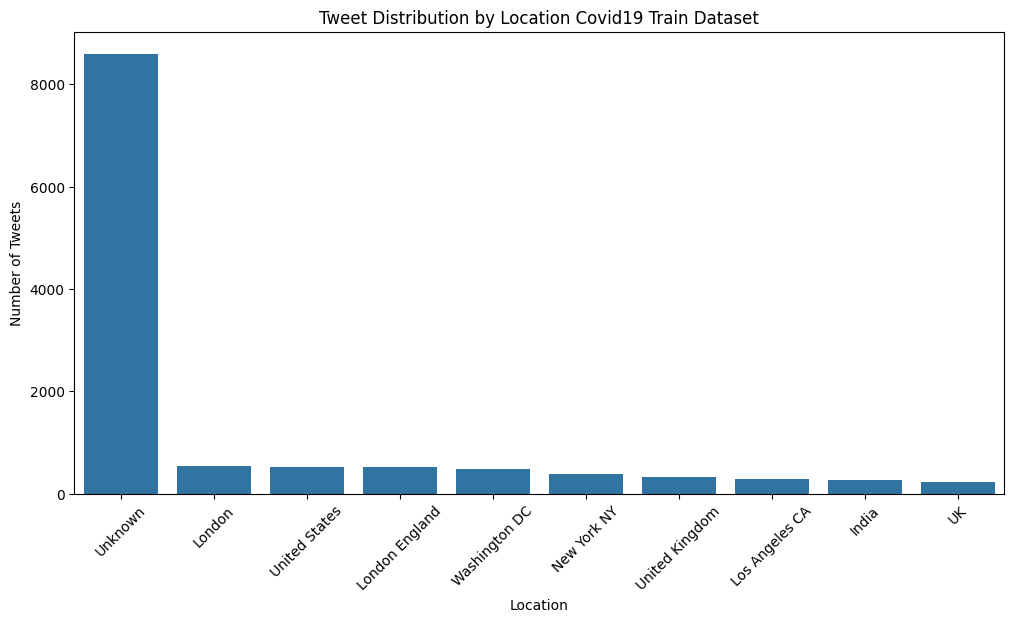

In [72]:
# ploting the distrubtion of tweets byy location
plt.figure(figsize=(12, 6))
sns.countplot(
    data=covid19_tweets_train_df,
    x="Location",
    order=covid19_tweets_train_df["Location"].value_counts().index[:10],
)
plt.title("Tweet Distribution by Location Covid19 Train Dataset")
plt.xlabel("Location")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.savefig(RESULTS_DIR + "Tweet Distribution by Location Covid19 Train Dataset.png")
plt.show()


# 5. Text Preprocessing

Preprocess the text data by removing stop words, punctuation, and applying tokenization and stemming/lemmatization.


In [73]:
print("covid19 train dataset columns: ", covid19_tweets_train_df.columns, sep="\n")
print("covid19 test dataset columns: ", covid19_tweets_test_df.columns, sep="\n")
print("sentiment140 dataset columns: ", sentiment140_df.columns, sep="\n")


covid19 train dataset columns: 
Index(['Location', 'date', 'text', 'Sentiment', 'target', 'year', 'month',
       'text_length', 'cleaned_text'],
      dtype='object')
covid19 test dataset columns: 
Index(['Location', 'date', 'text', 'Sentiment', 'target', 'text_length'], dtype='object')
sentiment140 dataset columns: 
Index(['target', 'date', 'text', 'year', 'month', 'text_length'], dtype='object')


In [75]:
# to ensure efficient processign we will drop irelevant columns
covid19_tweets_train_df.drop(
    columns=["date", "year", "month", "Location", "text_length"], inplace=True
)
covid19_tweets_test_df.drop(columns=["date", "Location", "text_length"], inplace=True)
sentiment140_df.drop(columns=["date", "year", "month", "text_length"], inplace=True)


In [76]:
print("covid19 train dataset columns: ", covid19_tweets_train_df.columns, sep="\n")
print("covid19 test dataset columns: ", covid19_tweets_test_df.columns, sep="\n")
print("sentiment140 dataset columns: ", sentiment140_df.columns, sep="\n")


covid19 train dataset columns: 
Index(['text', 'Sentiment', 'target', 'cleaned_text'], dtype='object')
covid19 test dataset columns: 
Index(['text', 'Sentiment', 'target'], dtype='object')
sentiment140 dataset columns: 
Index(['target', 'text'], dtype='object')


In [85]:
# Download NLTK data
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("punkt_tab")

# Load Dataset


# Text Preprocessing Function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove user @ references and '#' from hashtags
    text = re.sub(r"\@\w+|\#", "", text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"\d", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text


def lemetize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stopwords.words("english")
    ]
    # Join tokens back to string
    text = " ".join(tokens)
    return text


def stem_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Stem the tokens
    stemmer = nltk.PorterStemmer()
    tokens = [
        stemmer.stem(word) for word in tokens if word not in stopwords.words("english")
    ]
    # Join tokens back to string
    text = " ".join(tokens)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahdj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mahdj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mahdj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mahdj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [88]:
# Apply preprocessing to the text column
import time

for name, dataset in {
    "covid19_tweets_train_df": covid19_tweets_train_df,
    "covid19_tweets_test_df": covid19_tweets_test_df,
    "sentiment140_df": sentiment140_df,
}.items():
    start_time = time.time()
    print(f"processing {name} ...")
    print("start cleaning text ...")
    dataset["clean_text"] = dataset["text"].apply(preprocess_text)
    print("finished cleaning text after ", time.time() - start_time, " seconds")
    print("lemetizing text ...")
    dataset["lemetized_text"] = dataset["clean_text"].apply(lemetize_text)
    print("finished lemetizing text after ", time.time() - start_time, " seconds")
    print("stemming text ...")
    dataset["stemmed_text"] = dataset["clean_text"].apply(stem_text)
    print("finished stemming text after ", time.time() - start_time, " seconds")
    dataset.to_csv(f"{DATA_DIR}/{name}_processed.csv", index=False)
    print(
        "finished processing ",
        name,
        " after ",
        time.time() - start_time,
        " seconds",
        "saved to ",
        f"{DATA_DIR}/{name}_processed.csv",
    )
del name, dataset, start_time


processing covid19_tweets_train_df ...
start cleaning text ...
finished cleaning text after  0.7653524875640869  seconds
lemetizing text ...
finished lemetizing text after  229.03733348846436  seconds
stemming text ...
finished stemming text after  463.3248133659363  seconds
                                                text           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   

     target                                       cleaned_text  \
0   Neutral                                           and and    
1  Positive  advice talk to your neighbours family to excha...   
2  Positive  coronavirus australia woolworths to give elder...   
3  

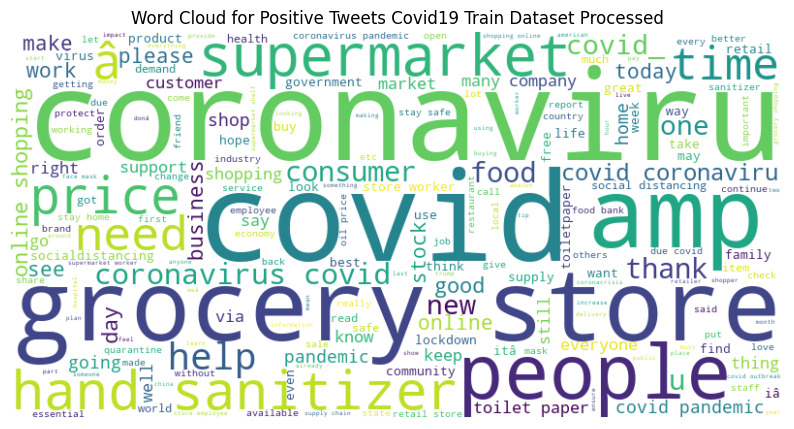

C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\1184679469.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


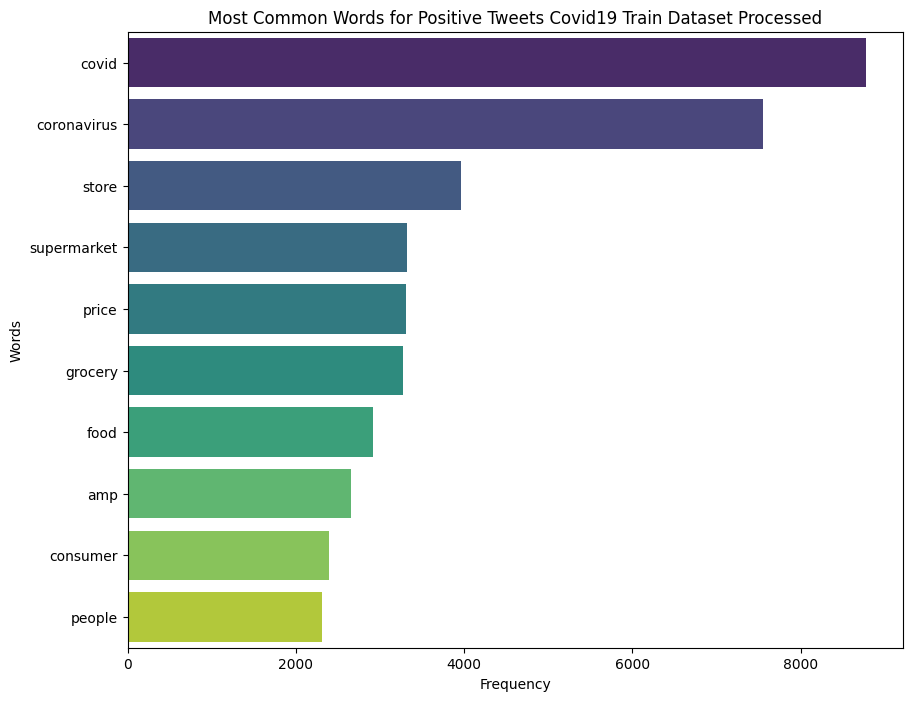

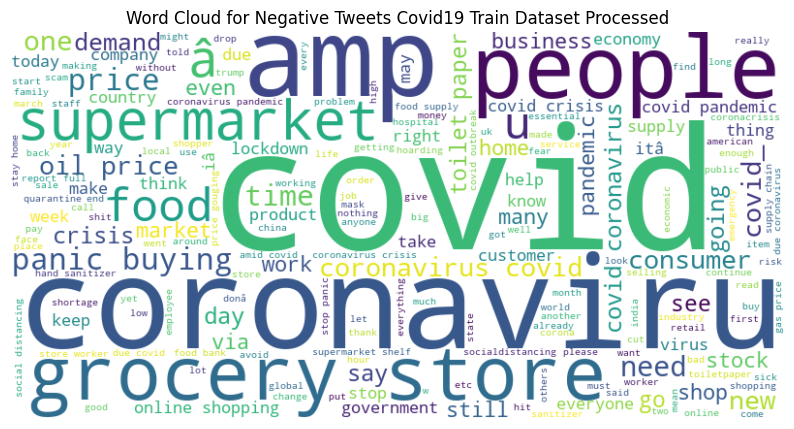

C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\1184679469.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


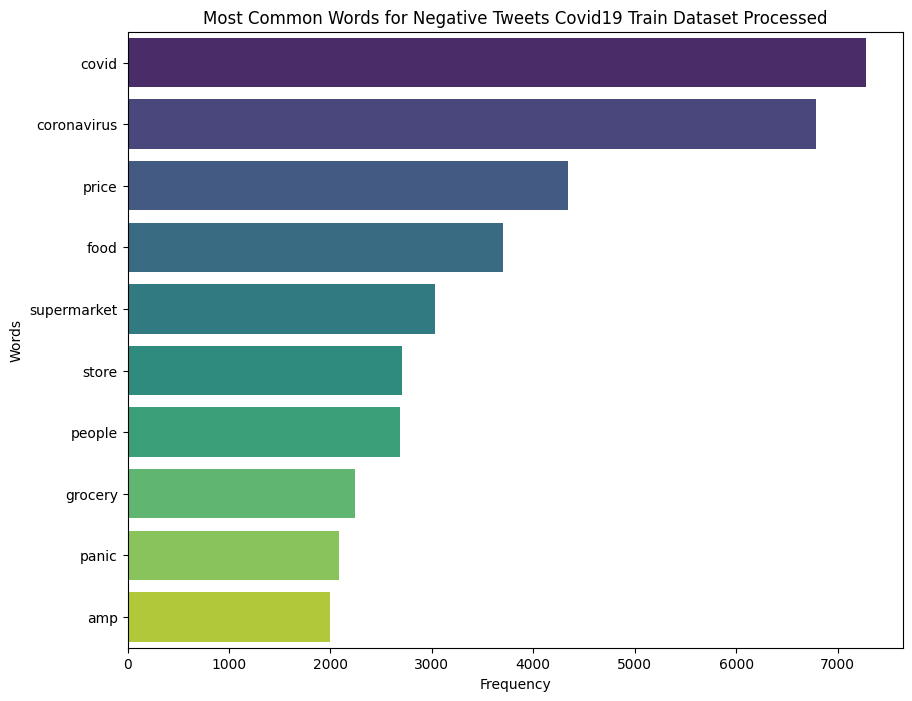

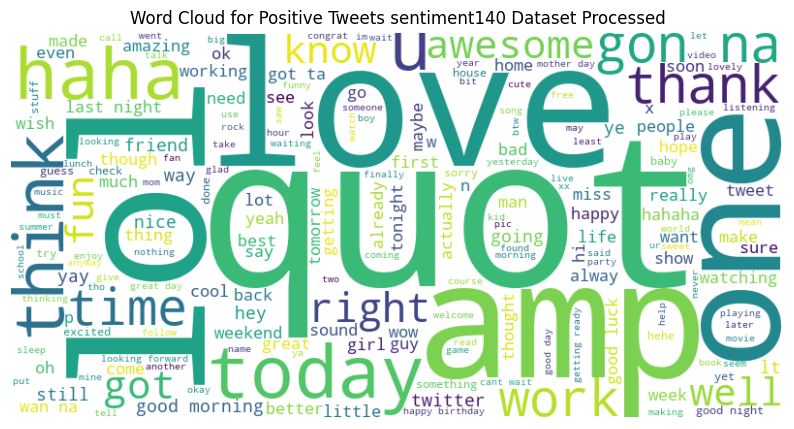

C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\1184679469.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


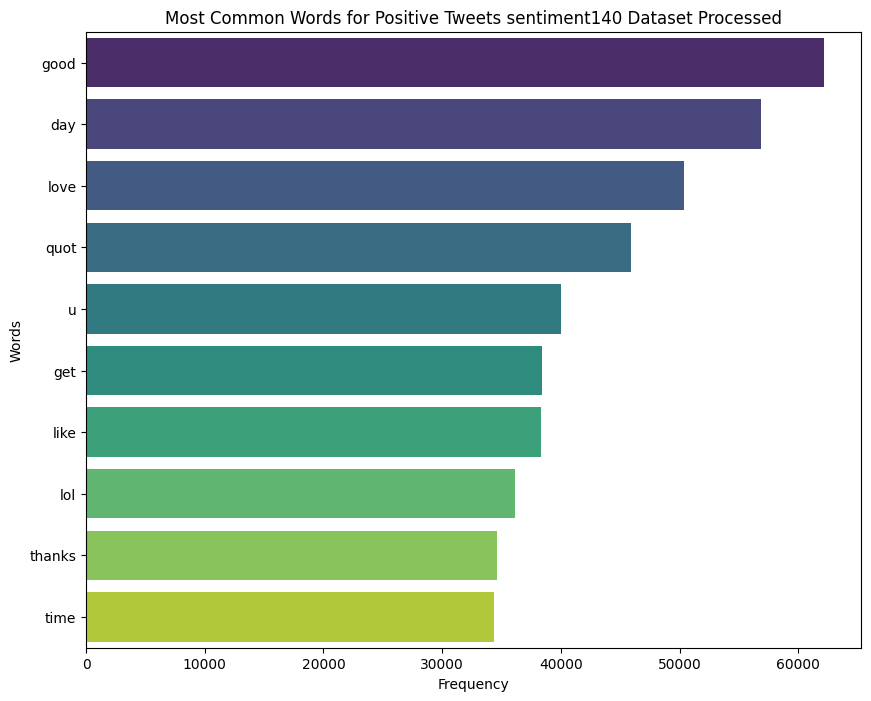

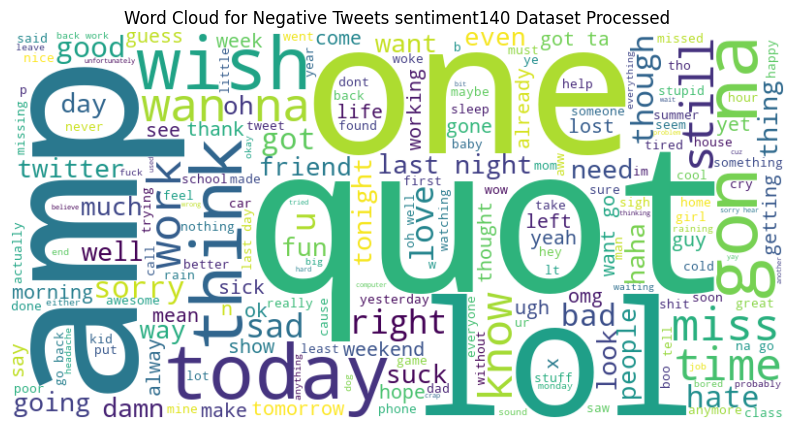

C:\Users\mahdj\AppData\Local\Temp\ipykernel_22692\1184679469.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


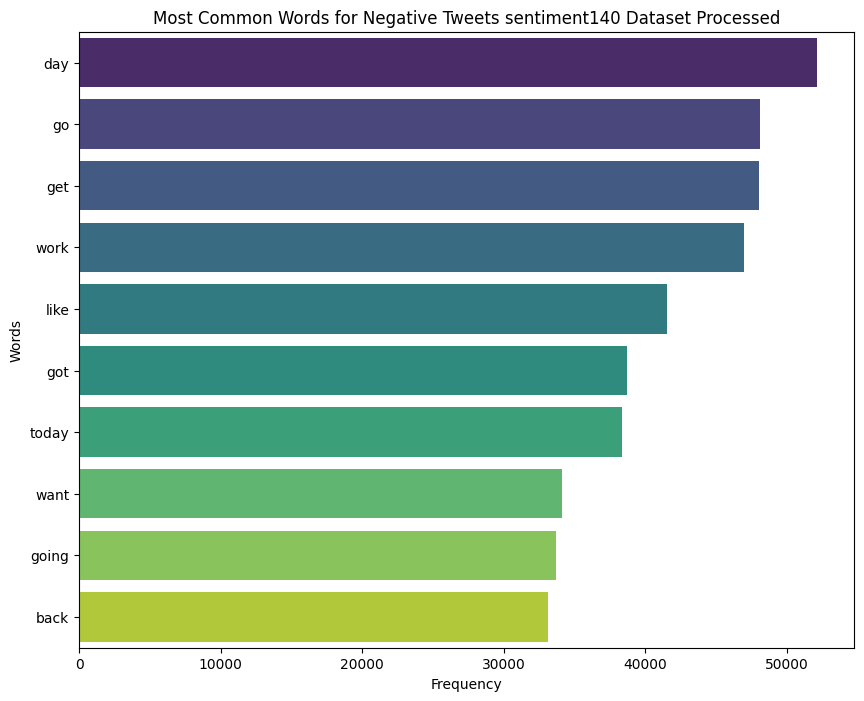

In [90]:
# ploting word cloud for new processed data
positive_tweets = " ".join(
    covid19_tweets_train_df[(covid19_tweets_train_df["target"] == "Positive")][
        "lemetized_text"
    ]
)
plot_word_cloud(
    positive_tweets, "Word Cloud for Positive Tweets Covid19 Train Dataset Processed"
)
plot_most_common_words(
    positive_tweets,
    "Most Common Words for Positive Tweets Covid19 Train Dataset Processed",
)
negative_tweets = " ".join(
    covid19_tweets_train_df[(covid19_tweets_train_df["target"] == "Negative")][
        "lemetized_text"
    ]
)
plot_word_cloud(
    negative_tweets, "Word Cloud for Negative Tweets Covid19 Train Dataset Processed"
)
plot_most_common_words(
    negative_tweets,
    "Most Common Words for Negative Tweets Covid19 Train Dataset Processed",
)

positive_tweets = " ".join(
    sentiment140_df[(sentiment140_df["target"] == 4)]["lemetized_text"]
)
plot_word_cloud(
    positive_tweets, "Word Cloud for Positive Tweets sentiment140 Dataset Processed"
)
plot_most_common_words(
    positive_tweets,
    "Most Common Words for Positive Tweets sentiment140 Dataset Processed",
)
negative_tweets = " ".join(
    sentiment140_df[(sentiment140_df["target"] == 0)]["lemetized_text"]
)
plot_word_cloud(
    negative_tweets, "Word Cloud for Negative Tweets sentiment140 Dataset Processed"
)
plot_most_common_words(
    negative_tweets,
    "Most Common Words for Negative Tweets sentiment140 Dataset Processed",
)

del positive_tweets, negative_tweets


# 6. Feature Extraction

Extract features from the text data using techniques like TF-IDF or word embeddings.


In [ ]:
# moving forward we will combine two datasets covid19 and sentiment140
# but before we will split sentiment140 dataset into train and test
# we will use the train dataset to train the model and the test dataset to evaluate the model
sentiment140_train_df, sentiment140_test_df = (
    train_test_split(  # Split the dataset into train and test sets
        sentiment140_df, test_size=0.2, random_state=42
    )
)
#  before merging we need to drop neutral sentiments from covid19 dataset
covid19_tweets_train_df = covid19_tweets_train_df[
    covid19_tweets_train_df["target"] != "Neutral"
]
covid19_tweets_test_df = covid19_tweets_test_df[
    covid19_tweets_test_df["target"] != "Neutral"
]
#  we will merge the two datasets
combined_train_df = pd.concat([covid19_tweets_train_df, sentiment140_train_df])
combined_test_df = pd.concat([covid19_tweets_test_df, sentiment140_test_df])

#  map the target column to 0 and 1
combined_train_df["target"] = combined_train_df["target"].map(
    {"Positive": 1, "Negative": 0, 4: 1, 0: 0}
)
combined_test_df["target"] = combined_test_df["target"].map(
    {"Positive": 1, "Negative": 0, 4: 1, 0: 0}
)

# save dataset for future use
combined_train_df.to_csv(f"{DATA_DIR}/combined_train.csv", index=False)
combined_test_df.to_csv(f"{DATA_DIR}/combined_test.csv", index=False)


In [91]:
# Feature Extraction
def generate_features(column):
    # Initialize the TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)

    # Fit and transform the processed tweets
    tfidf_features = tfidf_vectorizer.fit_transform(combined_train_df[column])
    tfidf_features_test = tfidf_vectorizer.transform(combined_test_df[column])

    # Convert the TF-IDF features to a DataFrame for better readability
    df_train = pd.DataFrame(
        tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
    )
    df_test = pd.DataFrame(
        tfidf_features_test.toarray(),
        columns=tfidf_vectorizer.get_feature_names_out(),
    )
    return df_train, df_test

# 7. Sentiment Analyses

Train a machine learning model (e.g., Logistic Regression, SVM, or a neural network) on the preprocessed data.
or use Large language models to predict sentiment from tweet text, or use statistical function to calculate polarity


## 7.1. Classification Models

we train diffrent calassification models using the features we created early via the tfidf method here we chose random forest, logistic regression and MLP classifier


In [ ]:
def evaluate_model(y_pred, y_test, model_name, column):
    """
    Function to evaluate the model using various metrics
    """
    print(f"{model_name} Model on {column}")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    confusion = confusion_matrix(y_test, y_pred)
    # ploting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} on {column} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{RESULTS_DIR}/{model_name}_{column}_confusion_matrix.png")
    plt.show()
    classification_rep = classification_report(y_test, y_pred)
    # save classification report to file
    with open(
        f"{RESULTS_DIR}/{model_name}_{column}_classification_report.txt", "w"
    ) as file:
        file.write(classification_rep)
    print(classification_rep)
    return accuracy, f1, recall, precision


In [ ]:
# Model Training
import pickle

tweets_columns = ["text", "clean_text", "lemetized_text", "stemmed_text"]
y_train = combined_train_df["target"]
y_test = combined_test_df["target"]
for column in tweets_columns:
    # Initialize the models
    logistic_regression_model = LogisticRegression(max_iter=1000, n_jobs=-1)
    rf_model = RandomForestClassifier(n_jobs=-1, max_depth=500)
    mlp_model = MLPClassifier(max_iter=1000)
    X_train, X_test = generate_features(column)
    # Train the Logistic Regression model
    logistic_regression_model.fit(X_train, y_train)

    # Train the SVM model
    rf_model.fit(X_train, y_train)

    # Train the MLP model
    mlp_model.fit(X_train, y_train)

    # Evaluate the Logistic Regression model
    y_pred_lr = logistic_regression_model.predict(X_test)

    lr_accuracy, lr_f1, lr_recall, lr_precision = evaluate_model(
        y_pred_lr, y_test, "Logistic Regression", column
    )

    # Evaluate the SVM model
    y_pred_rf = rf_model.predict(X_test)
    rf_accuracy, rf_f1, rf_recall, rf_precision = evaluate_model(
        y_pred_rf, y_test, "Random Forest", column
    )

    # Evaluate the MLP model
    y_pred_mlp = mlp_model.predict(X_test)
    mlp_accuracy, mlp_f1, mlp_recall, mlp_precision = evaluate_model(
        y_pred_mlp, y_test, "MLP Neural Network", column
    )

    # save the models
    with open(f"{RESULTS_DIR}/logistic_regression_{column}_model.pkl", "wb") as file:
        pickle.dump(logistic_regression_model, file)
    with open(f"{RESULTS_DIR}/random_forest_{column}_model.pkl", "wb") as file:
        pickle.dump(rf_model, file)
    with open(f"{RESULTS_DIR}/mlp_neural_network_{column}_model.pkl", "wb") as file:
        pickle.dump(mlp_model, file)

Logistic Regression Model
Accuracy: 0.7973760932944607
Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.80      0.80      3062
     Neutral       0.74      0.63      0.68      1553
    Positive       0.82      0.86      0.84      3617

    accuracy                           0.80      8232
   macro avg       0.78      0.77      0.77      8232
weighted avg       0.80      0.80      0.80      8232

Confusion Matrix:
 [[2460  191  411]
 [ 279  986  288]
 [ 340  159 3118]]

SVM Model
Accuracy: 0.7889941690962099
Classification Report:
               precision    recall  f1-score   support

    Negative       0.78      0.80      0.79      3062
     Neutral       0.74      0.61      0.67      1553
    Positive       0.81      0.85      0.83      3617

    accuracy                           0.79      8232
   macro avg       0.78      0.76      0.76      8232
weighted avg       0.79      0.79      0.79      8232

Confusion Matrix:
 [[

## 7.2. Large Language Models

we use bert uncased LLM to see tohe power of LLM in the task of sentimeent analyses using diffrent preprocessing methods
in this section we will use two approaches

- `Pre-Trained Model`: we will use a pretrained model on our test datset to see how well it can perform
- `Fine-Tuning Model`: we will try and fine tune our model on our dataset and see if it can enhance it performance


### 7.2.1. Pre-Trained LLM

we used the `distilbert-base-uncased-finetuned-sst-2-english` model


In [ ]:
from transformers import pipeline

for column in tweets_columns:
    repo_name = f"{column}_pretrained"
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    )
    print(f"starting prediction of {column} using pretrained model")
    results = sentiment_pipeline(combined_test_df[column].apply(str).tolist())
    parsed_results = [0 if result["label"] == "NEGATIVE" else 1 for result in results]

    combined_test_df[f"{column}_pretrained_sentiment"] = [
        result["label"] for result in results
    ]
    combined_test_df[f"{column}_pretrained_score"] = [
        result["score"] for result in results
    ]
    evaluation = {
        "accuracy": accuracy_score(combined_test_df["target"], parsed_results),
        "f1": f1_score(combined_test_df["target"], parsed_results),
        "precision": precision_score(combined_test_df["target"], parsed_results),
        "recall": recall_score(combined_test_df["target"], parsed_results),
    }

    print(f"Results for {column} column using pre-trained model:")
    for key, value in evaluation.items():
        print(f"{key}: {value}")

    # plot evaluation results
    evaluation_df = pd.DataFrame(evaluation, index=[0])
    evaluation_df.to_csv(f"{RESULTS_DIR}/{repo_name}_evaluation.csv", index=False)
    evaluation_df.plot(kind="bar", figsize=(10, 6))
    plt.title(f"Sentiment Analysis Evaluation for {column}")
    plt.ylabel("Score")
    plt.savefig(f"{RESULTS_DIR}/{repo_name}_evaluation.png")


### 7.2.2. Fine Tuning LLM

Train our LLM on our dataset


#### 7.2.2.1. Setup


In [ ]:
# init the tokenizer and data collator
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
# prepare dataset transformer to fit the model
from datasets import Dataset


def prepare_dataset(df: pd.DataFrame, column_selected) -> Dataset:
    """
    this function will prepare the dataset for the model

    Args:
        df: pd.DataFrame : the cleaned dataframe
    return:
        Dataset : the dataset for the model

    """

    train = df[[column_selected, "target"]].sample(frac=0.8, random_state=1542)
    test = df[[column_selected, "target"]].drop(train.index)
    print(train.head())
    # Convert pandas DataFrames to Hugging Face datasets
    train_dataset = Dataset.from_pandas(train.reset_index(drop=True))
    eval_dataset = Dataset.from_pandas(test.reset_index(drop=True))

    # Rename columns to fit model requirements
    train_dataset = train_dataset.rename_column(column_selected, "text")
    train_dataset = train_dataset.rename_column("target", "labels")
    eval_dataset = eval_dataset.rename_column(column_selected, "text")
    eval_dataset = eval_dataset.rename_column("target", "labels")
    print(train_dataset[0])
    print(eval_dataset[0])
    return train_dataset, eval_dataset


def preprocess_function(dataset):
    """this function will tokenize the dataset"""
    texts = [str(t) for t in dataset["text"]]
    return tokenizer(texts, truncation=True)


In [ ]:
# define evaluation function
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    recall = recall_score(labels, predictions)
    precision = precision_score(labels, predictions)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
        "precision": precision,
    }


In [ ]:
# setup device for training
#  test cuda availability

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print(torch.cuda.is_available())
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


#### 7.2.2.2. Model Training


In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

models = {
    column: AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=2
    )
    for column in tweets_columns
}
for column in tweets_columns:
    # set name for the repo
    repo_name = f"tweet_sentiment_analysis_{column}"

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=repo_name,  # output directory
        learning_rate=2e-5,
        per_device_train_batch_size=64,  # reduced batch size
        per_device_eval_batch_size=64,  # reduced batch size
        num_train_epochs=4,
        weight_decay=0.01,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        # push_to_hub=True,
        logging_dir=f"./logs/{repo_name}",
        fp16=True,  # enable mixed precision on CUDA
        dataloader_num_workers=2,
        dataloader_pin_memory=True,
    )

    #  loading dataset
    train_dataset, eval_dataset = prepare_dataset(combined_train_df, column)
    tokenized_train = train_dataset.map(preprocess_function, batched=True)
    tokenized_test = eval_dataset.map(preprocess_function, batched=True)

    # Load model and move it to the appropriate device
    model = models[column]

    model = model.to(device)

    # Check if labels are within the expected range
    num_labels = model.config.num_labels
    for dataset in [tokenized_train, tokenized_test]:
        labels = dataset["labels"]
        if not all(0 <= label < num_labels for label in labels):
            raise ValueError(f"Found labels outside the range [0, {num_labels - 1}]")

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Start training with error handling
    try:
        print(f"Training model on {column} column")
        trainer.train()
        print(f"Training completed for {column} column")
    except RuntimeError as e:
        print(f"Error during training: {e}")
        print("Try reducing batch size or using CPU if CUDA memory is insufficient")

    # Convert trainer's log_history to a DataFrame for easier plotting
    history = pd.DataFrame(trainer.state.log_history)

    # Plot training (and evaluation) loss if available
    plt.figure(figsize=(10, 6))
    if "loss" in history.columns:
        plt.plot(history["step"], history["loss"], label="Training Loss")
    if "eval_loss" in history.columns:
        plt.plot(history["step"], history["eval_loss"], label="Evaluation Loss")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title(f"Training and Evaluation Loss History {column}")
    plt.legend()
    plt.savefig(RESULTS_DIR + f"{column}_training_eval_loss_history.png")
    plt.show()

    eval_results = trainer.evaluate()

    # Remove non-metric keys if present
    metric_keys = [
        k
        for k in eval_results.keys()
        if k
        in [
            "eval_loss",
            "eval_accuracy",
            "eval_f1",
            "eval_precision",
            "eval_recall",
        ]
    ]

    # Save the evaluation metrics into a DataFrame and export as CSV
    metrics_df = pd.DataFrame([{k: eval_results[k] for k in metric_keys}])
    metrics_df.to_csv(RESULTS_DIR + f"{column}_evaluation_metrics.csv", index=False)

    # Plot evaluation metrics as a bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(metric_keys, [eval_results[k] for k in metric_keys])
    plt.ylabel("Metric Value")
    plt.title(f"Evaluation Metrics {column}")
    plt.savefig(RESULTS_DIR + f"{column}_evaluation_metrics.png")
    plt.show()

    # saving the models
    trainer.save_model(repo_name)
    tokenizer.save_pretrained(repo_name)
    print(f"Model and tokenizer saved to {repo_name}")


#### 7.2.2.3. Model Evaluation


In [ ]:
# evaluate the finetuned model on test dataset


for column in tweets_columns:
    repo_name = f"{column}_fine_tuned"

    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model=f"./{repo_name}/",
    )
    results = sentiment_pipeline(combined_test_df[column].apply(str).tolist())
    parsed_results = [0 if result["label"] == "NEGATIVE" else 1 for result in results]

    combined_test_df[f"{column}_finetuned_sentiment"] = [
        result["label"] for result in results
    ]
    combined_test_df[f"{column}_finetuned_score"] = [
        result["score"] for result in results
    ]
    evaluation = {
        "accuracy": accuracy_score(combined_test_df["target"], parsed_results),
        "f1": f1_score(combined_test_df["target"], parsed_results),
        "precision": precision_score(combined_test_df["target"], parsed_results),
        "recall": recall_score(combined_test_df["target"], parsed_results),
    }

    print(f"Results for {column} column using fine-tuned model:")
    for key, value in evaluation.items():
        print(f"{key}: {value}")

    # plot evaluation results
    evaluation_df = pd.DataFrame(evaluation, index=[0])
    evaluation_df.to_csv(f"{RESULTS_DIR}/{repo_name}_evaluation.csv", index=False)
    evaluation_df.plot(kind="bar", figsize=(10, 6))
    plt.title(f"Sentiment Analysis Evaluation for {column}")
    plt.ylabel("Score")
    plt.savefig(f"{RESULTS_DIR}/{repo_name}_evaluation.png")


## 7.3. Statistical Model

here we use the `TextBlob` snetiment analyses methode that uses statistical calculation to calculate polarity where The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.


In [ ]:
%pip install -q textblob
from textblob import TextBlob


# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity


# Create a function to get Polarity
def getPolarity(text):
    polarity = TextBlob(text).sentiment.polarity
    # shift the polarity score to fit the target range of 0 and 1
    return 1 if polarity > 0 else 0


def getInsight(score):
    if score == 0:
        return "Negative"
    elif score == 1:
        return "Positive"
    else:
        return "Neutral"


def analyze_sentement(df, target: str = "text"):
    # Now we create a new column for what we just did and add it to the Tweet_df dataframe
    print(f"Analyzing {target} using textblob sentiment analysis")
    df.dropna(subset=[target], inplace=True)
    df[f"{target}_Subjectivity"] = df[target].apply(getSubjectivity)
    df[f"{target}_Polarity"] = df[target].apply(getPolarity)
    # Now display data

    # Group the range of Polarity into different categories

    df[f"{target}_Insight"] = df[f"{target}_Polarity"].apply(getInsight)

    return df


In [92]:
for column in tweets_columns:
    df = analyze_sentement(combined_test_df, column)
    statistical_model_evaluation = {
        "accuracy": accuracy_score(df["target"], df[f"{column}_Polarity"]),
        "f1": f1_score(df["target"], df[f"{column}_Polarity"]),
        "precision": precision_score(df["target"], df[f"{column}_Polarity"]),
        "recall": recall_score(df["target"], df[f"{column}_Polarity"]),
    }
    for key, value in statistical_model_evaluation.items():
        print(f"{key}: {value}")

    # pplot and save teh results
    evaluation_df = pd.DataFrame(statistical_model_evaluation, index=[0])
    evaluation_df.to_csv(
        f"{RESULTS_DIR}/{column}_statistical_evaluation.csv", index=False
    )
    evaluation_df.plot(kind="bar", figsize=(10, 6))
    plt.title(f"Statistical Analysis Evaluation for {column}")
    plt.ylabel("Score")
    plt.savefig(f"{RESULTS_DIR}/{column}_statistical_evaluation.png")
    plt.show()


NameError: name 'tweets_columns' is not defined